# Projeto de Transfer Learning com Python
O projeto consiste em aplicar o método Transfer Learning em uma rede de Deep Learning aqui no COLAB, utilizando do dataset disponibilizado pelo TensorFlow de **Cats Vs Dogs**, para identificar se é um **Cat** ou um **Dog** haha!

Me baseei no exemplo que usou o dataset do MNIST:
https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

---
- Como é no Colab, não precisei baixar manualmente o dataset via link da Microsoft - o **tensorflow_datasets** já trás o dataset dos Gatos e Cachorros pronto, com split configurado.
- Esse código utiliza a rede pré-treinada **MobileNetV2** como base, que é leve e mais rápida, caso quiser mais eficiência e tiver capacidades, é possível utilizar **InceptionV3, ResNet50**.
- Fiz a primeira execução com o modelo separando em 80% para treino e 20% para testes de aprendizado, a acurácia foi de cerca de 60%.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("Versão do Tensorflow: ", tf.__version__)
print("GPU disponível: ", tf.config.list_physical_devices('GPU'))

Versão do Tensorflow:  2.19.0
GPU disponível:  []


## 1) Importar bibliotecas / checar GPU

- **import tensorflow as tf** importa o TensorFlow e o associa ao alias **tf**. Quase todas as chamadas ao TF vêm via **tf.***.
---
- **import tensorflow_datasets as tfds** importa o pacote **tensorflow_datasets**, que fornece datasets prontos (download, parsing e metadata) e utilitários para carregá-los facilmente.
---
- **import matplotlib.pyplot as plt** importa uma subblioteca de plotagem **pyplot** do Matplotlib, com o alias **plt** - usado para visualizar imagens e gráficos.
---
- O primeiro print mostra a versão do Tensor Flow.
---
- O segundo print lista dispositivos físicos do tipo **'GPU'**. Em Colab, é comum ver algo como **[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]** se o runtime tiver GPU.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.D1SUJ9_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


## 2) Carregar o DataSet (Cães e Gatos)

- **tfds.load** pede para o **tfds** baixar (se necessário) e retornar o dataset chamado **cats_vs_dogs**.
---
- **split=['train[:80%]'. 'train[80%:]']** faz um split do conjunto orignal em duas partes: os primeiros 80% para treino e os últimos 20% para teste/validação. Isso evita precisar baixar e manipular arquivos manualmente.
---
- **shuffle_files=True** faz o TFDS embaralhar a ordem dos arquivos antes de montar o pipeline (útil para evitar padrão de leitura seriada).
---
- **as_supervised=True** faz o dataset retornar tuplas **(imagem, label)** ao invés de dicionários com várias features.
---
- **with_info=True** retorna também **ds_info**, objero com metadados (número de classes, descrição das features, tamanho aproximado, etc.) Aqui atribuimos **(ds_train, ds_test), ds_info** - **ds_train** e **ds_test** são **tf.data.Dataset**.

In [ ]:
IMG_SIZE = 160
BATCH_SIZE = 32

def preprocess(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32) / 255.00
  return image, label

train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 3) Pré-processamento e batching

- **IMG_SIZE = 160** é o tamanho para o lado (altura/largura) das imagens de entrada, aqui 160x160. É um valor razoável para MobileNetV2 (compromisso entre velocidade e informação).
---
- **BATCH_SIZE = 32** é quantas amostras por batch. 32 é default comum; pode ajustar conforme memória/GPU.
---
- **def process(image, label):**...**return image, label** é a função que será aplicada a cada exemplo:
  - **tf.image.resize(image, (IMG_SIZE, IMG_SIZE))** redimensiona a imagem para **(160,160)**. Usa interpolação bilínear por padrão.
  - **tf_cast(image, tf.float32)** converte os pixels (normalmente **uint8**) para **float32**.
  - **/ 255.0** normaliza os pixels para o intervalo **[0.0, 1.0]**.
  - **return image, label** devolve par pronto para treino.
---
- **train_ds = ds_train.map(preprocess)map** aplica **preprocess** a cada exemplo do dataset de treino.
---
- **.shuffle(1000)** embaralha as amostras usando um buffer de 1000 exemplos. Um buffer maior => embaralhamento mais completo, mas usa mais memória.
---
- **.batch(BATCH_SIZE)** agrupa amostras em batches de 32.
---
- **.prefetch(tf.data.AUTOTUNE)** sobrepõe a preparação dos batches com o treinamento para performance (AUTOTUNE deixa o TF escolher o melhor buffer).
---
- **test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(...)** para o conjunto de teste não usamos **shuffle** (normalmente não se embaralha para avaliação).

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
])

## 4) Data augmentation (aumentar dados)

- **tf.keras.Sequential([...])** cria uma sequência de camadas que serão aplicadas em série. Aqui serve como mini-modelo de augmentations.
---
- **tf.keras.layers.RandomFlip("horizontal")** aplica flip horizontal aleatório (espelha imagens) útil para tornar o modelo invariante à orientação horizontal.
---
- **tf.keras.layers.RandomRotation(0.1)** roda a imagem aleatoriamente em um pequeno ângulo. **0.1** significa até +-10% de uma volta completa - isto é, aproximadamente +-36° (valor em fração da rotação completa). (Essa rotação é aplicada aleatoriamente durante treino; em validação/teste as camadas de preprocessing do Keras ficam inativas.)
---
Augmentation reduz overfitting e aumenta robustez; é aplicado apenas no treino (normalmente).

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 5) Carregar o modelo pré-treinado (base)

- **tf.keras.applications.MobileNetV2(...)** carrega a arquitetura MobileNetV2 com pesos pré-treinados no ImageNet:
  - **input_shape=(IMG_SIZE, IMG_SIZE, 3)** é o formato de entrada (altura, largura, canais).
  - **include_top=False** não inclui a cabeça/classificador final (camadas **Dense**) da rede pré-treinada; assim usamos a parte convulocional como extrator de features.
  - **weights='imagenet'** inicializa com pesos treinados no ImageNet.
---
- **base_model.trainable = False** congela os pesos da base: durante o primeiro estágio de treino apenas as camadas adicionadas por você serão treinadas. Isso é padrão em Transfer Learning para preservar features já aprendidas e evitar overfitting com poucas amostras.

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 6) Montar o modelo final

- **inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))** define a camada de entrada do modelo com shape (160, 160, 3).
---
- **x = data_augmentation(inputs)** Aplica a sequência de augmentations definida antes diretamente na entrada - isso significa que em cada epoch as imagens podem chegar levemente alteradas (aplicado apenas em modo treino).
---
- **x = tf.keras.applications.mobilenet_v2.preprocess_input(x)** aplica a função de pré-processamento específico do MobileNetV2 (ela escala/centraliza os pixels conforme o que a rede espera - tipicamente transforma para o intervalo [-1, 1] e faz a normalização específica).
**Atenção**: Nós já dividimos por **255.0** na função **preprocess** do **tf.data**. Isso pode causar normalização dupla.
  - Eu recomendo manter **/255.0** no pipeline e remover **preprocess_input** do modelo; desse modo você garante que a escala é consistente. É importante ter consistência - caso contrário as imagens podem acabar com escala errada e o desempenho cai.
---
- **x = base_model(x, training=False)** Passa **x** pea base convolucional. **training=False** garante que camadas que se comportam diferente em treino/aval (ex.: BatchNorm) funcionem em modo inferência, o que é recomendado quando a base está congelada.
---
- **x = tf.keras.layers.GlobalAveragePooling2D()(x) converte o tensor de formas espaciais (HxWxC) para um vetor C, fazendo a média em cada mapa de feature. Reduz muito parâmetros e evita **Flatten()** com redes muito grandes.
---
- **x = tf.keras.layers.Dropout(0.2)(x)** Dropout com taxa 0.2: durante treino desliga aleatoriamente 20% dos nós para reduzir overfitting.
---
- **outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)** é a camada densa final com 1 neurônio e **sigmoid** - saída entre 0 e 1; usada para classificação binária (cat x dog). Valor > 0.5 => classe positiva (por convenção).
---
- **model = tf.keras.Model(inputs, outputs)** instancia o modelo Keras conectando a entrada e a saída definidas.

---

## 7) Compilar o modelo

- **optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)** é um otimizador Adam com LR pequeno (1e-4) - padrão razoável para Transfer Learning (evita grandes mudanças nos pesos das camadas finais).
---
- **loss='binary_crossentropy'** é uma função de perda para problemas binários com saída sigmoide.
---
- **metrics=['accuracy']** é uma métrica utilizada para monitoramento durante treino e avaliação.

In [ ]:
history = model.fit(train_ds, validation_data=test_ds, epochs=25)

Epoch 1/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 593s 1s/step - accuracy: 0.4994 - loss: 0.7206 - val_accuracy: 0.5239 - val_loss: 0.6905
Epoch 2/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 625s 1s/step - accuracy: 0.5070 - loss: 0.7085 - val_accuracy: 0.5436 - val_loss: 0.6893
Epoch 3/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 576s 989ms/step - accuracy: 0.5064 - loss: 0.7085 - val_accuracy: 0.5843 - val_loss: 0.6868
Epoch 4/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 626s 994ms/step - accuracy: 0.5020 - loss: 0.7050 - val_accuracy: 0.5411 - val_loss: 0.6871
Epoch 5/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 578s 992ms/step - accuracy: 0.5171 - loss: 0.7009 - val_accuracy: 0.5860 - val_loss: 0.6834
Epoch 6/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 523s 897ms/step - accuracy: 0.5317 - loss: 0.6943 - val_accuracy: 0.5613 - val_loss: 0.6826
Epoch 7/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 615s 989ms/step - accuracy: 0.5335 - loss: 0.6923 - val_accuracy: 0.5957 - val_loss: 0.6811
Epoch 8/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.5365 - loss: 0.

## 8) Treinar

- **model.fit(...)** inicia o treinamento:
   - **train_ds** é o dataset de treino (já batched e com preprocessing).
   - **validation_data=test_ds** usa o conjunto de teste/validação para acompanhar métricas entre épocas.
   - **epochs=5** roda 5 épocas completas. Normalmente esse número é apenas inicial; costuma-se treinar mais e usar **callbacks** (EarlyStopping, ModelCheckpoint) para salvar o melhor modelo e evitar overfitting.
   ---
- **history** guarda a história de treino (loss,acc por época), útil para plotar curva de aprendizado.

In [ ]:
loss, acc = model.evaluate(test_ds)
print(f"Acurácia final: {acc*100:.2f}%")

146/146 ━━━━━━━━━━━━━━━━━━━━ 100s 680ms/step - accuracy: 0.6062 - loss: 0.6696
Acurácia final: 60.53%


## 9) Avaliar e mostrar resultado final

- **model.evaluate(test_ds)** avalia o modelo no dataset de teste e retorna (por ordem) a perda e os valores das métricas (aqui: accuracy).
---
- **print** formata a acurácia como porcentagem com duas casas decimais e imprime.

In [ ]:
import numpy as np

def show_one_prediction(dataset, model):
    for batch in dataset.take(1):
        # batch can be (images, labels) either batched or not
        images, labels = batch
        if len(images.shape) == 4:   # batched -> (B,H,W,3)
            img = images[3]
            lab = labels[3]
        else:                        # não batched -> (H,W,3)
            img = images
            lab = labels

        img_np = img.numpy()
        # se a imagem estiver pré-processada para [-1,1] (MobileNet preprocess), reescale para exibir:
        if img_np.min() < 0:
            disp = (img_np + 1.0) / 2.0
        else:
            disp = img_np

        plt.imshow(np.clip(disp, 0, 1))
        plt.axis("off")
        pred = model.predict(np.expand_dims(img_np, axis=0))[0,0]
        print("Prob.(Cachorro):", float(pred))
        print("Previsão:", "Cachorro" if pred >= 0.5 else "Gato", "| Valor real:", "Cachorro" if int(lab.numpy())==1 else "Gato")
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Prob.(Cachorro): 0.5971774458885193
Previsão: Cachorro | Valor real: Cachorro


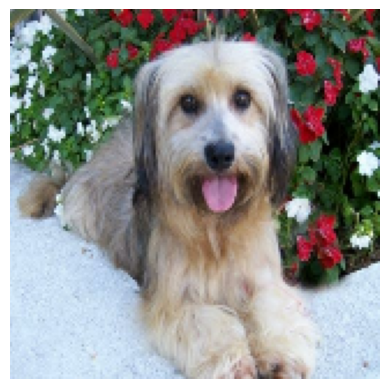

In [ ]:
show_one_prediction(test_ds, model)